# Import libraries

In [ ]:
!pip install kaggle

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, losses, layers

import shutil
import json

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras import optimizers

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Data Preparation

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# Download Dataset
!kaggle datasets download -d ananthu017/emotion-detection-fer

 98% 64.0M/65.2M [00:03<00:00, 22.8MB/s]
100% 65.2M/65.2M [00:03<00:00, 17.8MB/s]


In [ ]:
!unzip -q /content/emotion-detection-fer.zip

In [ ]:
!mkdir data

In [ ]:
shutil.move('/content/train', '/content/data')

'/content/data/train'

In [ ]:
shutil.move('/content/test', '/content/data')

'/content/data/test'

Sample happy image:


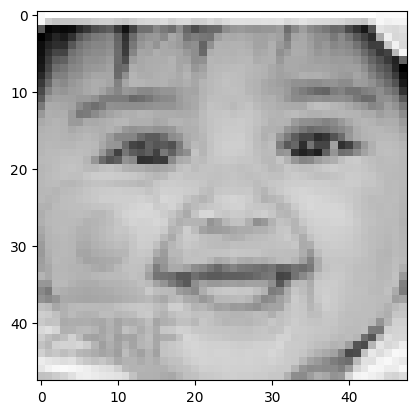


Sample sad image:


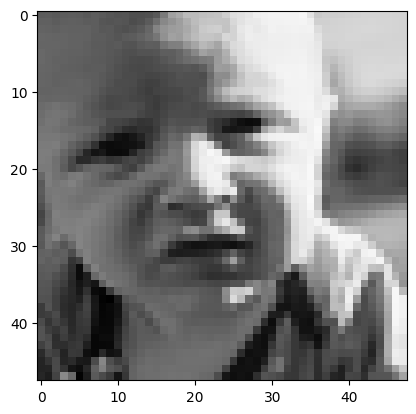

In [ ]:
base_dir = "/content/data/train"
happy_dir = os.path.join(base_dir, "happy/")
sad_dir = os.path.join(base_dir, "sad/")

print("Sample happy image:")
plt.imshow(load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.imshow(load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
plt.show()


In [ ]:
# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")



Each image has shape: (48, 48, 3)
The maximum pixel value used is: 255.0


# Create model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.9:
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
def image_generator(directory):
    datagen = ImageDataGenerator(rescale=1./255)

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    generator = datagen.flow_from_directory(directory=directory,
                                                        target_size=(48, 48),
                                                        batch_size=10,
                                                        class_mode='categorical')

    return generator


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

# plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

In [ ]:
# Save generator in a variable
gen = image_generator('/content/data/train')
test_gen = image_generator('/content/data/test')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
class_indices = gen.class_indices
class_indices

{'angry': 0,
 'disgusted': 1,
 'fearful': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprised': 6}

In [ ]:
# Write dictionary to JSON file
with open('emotion_class_indices.json', 'w') as json_file:
    json.dump(class_indices, json_file)

**Simple CNN**

In [ ]:
# Instantiate the callback
callbacks = myCallback()

# Define the model
model = tf.keras.models.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
    layers.MaxPooling2D(2, 2),
    # Convolutional Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # Convolutional Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    # Flatten the output for the fully connected layers
    layers.Flatten(),
    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),
    # Output Layer
    layers.Dense(7, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [ ]:
# Train the model
history = model.fit(x=gen,
                    epochs=50,
                    shuffle = True,
                    callbacks=[callbacks],
                    validation_data = test_gen)

Epoch 1/50
2871/2871 [==============================] - 32s 10ms/step - loss: 1.5739 - accuracy: 0.3770 - val_loss: 1.3646 - val_accuracy: 0.4781
Epoch 2/50
2871/2871 [==============================] - 27s 10ms/step - loss: 1.3045 - accuracy: 0.5016 - val_loss: 1.3204 - val_accuracy: 0.4990
Epoch 3/50
2871/2871 [==============================] - 27s 9ms/step - loss: 1.1946 - accuracy: 0.5474 - val_loss: 1.2376 - val_accuracy: 0.5336
Epoch 4/50
2871/2871 [==============================] - 26s 9ms/step - loss: 1.1059 - accuracy: 0.5806 - val_loss: 1.2012 - val_accuracy: 0.5351
Epoch 5/50
2871/2871 [==============================] - 27s 9ms/step - loss: 1.0289 - accuracy: 0.6081 - val_loss: 1.2114 - val_accuracy: 0.5414
Epoch 6/50
2871/2871 [==============================] - 26s 9ms/step - loss: 0.9458 - accuracy: 0.6418 - val_loss: 1.2434 - val_accuracy: 0.5387
Epoch 7/50
2871/2871 [==============================] - 30s 10ms/step - loss: 0.8728 - accuracy: 0.6710 - val_loss: 1.2729 - val

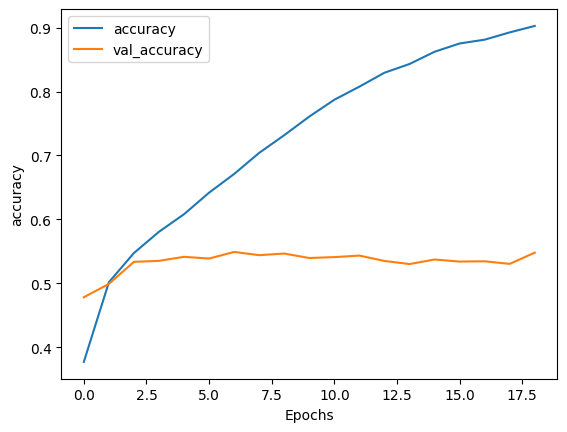

In [ ]:
plot_graphs(history, "accuracy")

In [ ]:
model.save('/content/emotion_model_v2.keras')

**Transfer Learning with VGG16 pretrained model**

In [ ]:
vgg16 = VGG16(input_shape=(48, 48, 3), weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
output = Flatten()(vgg16.output)
output = Dense(500, activation='relu')(output)
output = Dense(100, activation='relu')(output)
output = Dropout(0.5)(output)
output = Dense(7, activation='softmax')(output)

model = Model(inputs=vgg16.input, outputs=output)
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
callbacks = myCallback()

In [ ]:
# Train the model
history = model.fit(x=gen,
                    epochs=50,
                    shuffle = True,
                    callbacks=[callbacks],
                    validation_data = test_gen)

Epoch 1/50
2871/2871 [==============================] - 31s 11ms/step - loss: 1.2173 - accuracy: 0.5359 - val_loss: 1.5919 - val_accuracy: 0.4457
Epoch 2/50
2871/2871 [==============================] - 36s 12ms/step - loss: 1.1933 - accuracy: 0.5484 - val_loss: 1.5762 - val_accuracy: 0.4411
Epoch 3/50
2871/2871 [==============================] - 36s 13ms/step - loss: 1.1677 - accuracy: 0.5557 - val_loss: 1.5964 - val_accuracy: 0.4443
Epoch 4/50
2871/2871 [==============================] - 31s 11ms/step - loss: 1.1578 - accuracy: 0.5637 - val_loss: 1.6134 - val_accuracy: 0.4404
Epoch 5/50
2871/2871 [==============================] - 36s 13ms/step - loss: 1.1372 - accuracy: 0.5669 - val_loss: 1.6144 - val_accuracy: 0.4425
Epoch 6/50
2871/2871 [==============================] - 31s 11ms/step - loss: 1.1215 - accuracy: 0.5714 - val_loss: 1.6619 - val_accuracy: 0.4412
Epoch 7/50
2871/2871 [==============================] - 37s 13ms/step - loss: 1.1050 - accuracy: 0.5821 - val_loss: 1.7225 -

In [ ]:
print(f"Your model reached the desired accuracy after {len(history.epoch)} epochs")

Your model reached the desired accuracy after 50 epochs


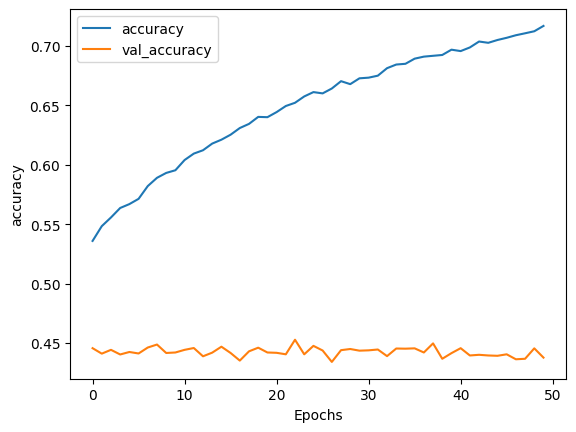

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
# plot_graphs(history, "loss")

In [ ]:
model.save('/content/emotion_model_vgg16.keras')

In [ ]:
if not "accuracy" in history.model.metrics_names:
    print("Use 'accuracy' as metric when compiling your model.")
else:
    print("The metric was correctly defined.")

The metric was correctly defined.


# Predict new sample

Saving stickers-sad-face-crying.jpg to stickers-sad-face-crying (3).jpg
Saving vector-emoji-angry-face-cute-600nw-1927365128.webp to vector-emoji-angry-face-cute-600nw-1927365128.webp
Saving happiness-1.jpg to happiness-1 (6).jpg
1/1 [==============================] - 0s 18ms/step
Predicted class: happy
Class probabilities: [[3.6289913e-03 2.7132539e-13 1.1522020e-03 7.7704513e-01 1.8462232e-01
  3.3551313e-02 1.8974951e-08]]


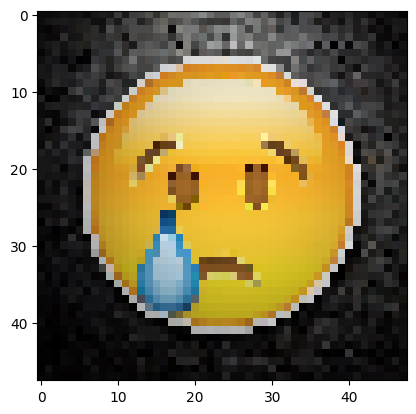

1/1 [==============================] - 0s 17ms/step
Predicted class: surprised
Class probabilities: [[5.5075269e-03 6.9853486e-14 1.2627726e-04 3.3686107e-03 1.1024653e-03
  1.6553162e-04 9.8972964e-01]]


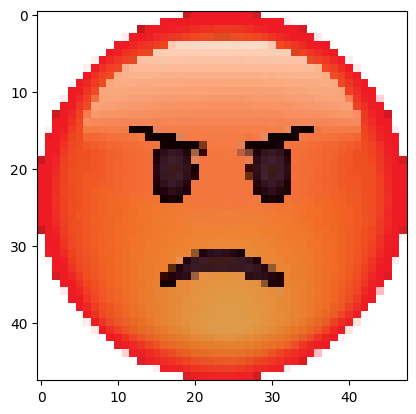

1/1 [==============================] - 0s 18ms/step
Predicted class: happy
Class probabilities: [[1.3043499e-12 0.0000000e+00 6.8598228e-16 1.0000000e+00 1.9879936e-08
  3.4681789e-11 1.5350723e-15]]


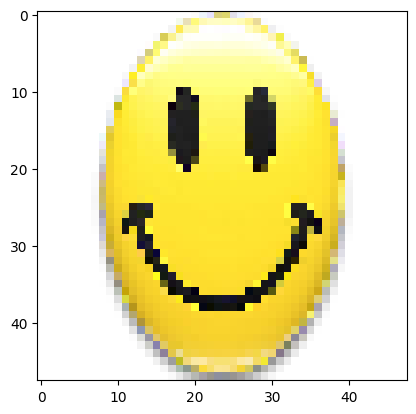

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(48, 48))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  predictions = model.predict(images, batch_size=10)

  # Get the predicted class index
  predicted_class_index = np.argmax(predictions)

  # Get the predicted class label from the 'gen' variable
  predicted_class = list(class_names.keys())[list(class_names.values()).index(predicted_class_index)]

  # Print the prediction
  print("Predicted class:", predicted_class)
  print("Class probabilities:", predictions)

  plt.imshow(img)
  plt.show()